<a href="https://colab.research.google.com/github/boletix/Predict-Future-Sales/blob/main/NOCCO_units.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Archivo para visualizar:
- Número de cleintes activos
- Clientes por canal (Conveniencia, FItness, Horeca, etc...)
- Predicción de unidades futras
- Ver que clientes deberían hacer pedidos
- Estudiar mejores referencias y dinámicas de ventas por referencias


# Parte 1: Cargar datos de Genero y hacer un Excel con los clientes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_2021 = '/content/drive/MyDrive/NOCCO/NOCCO/Orders_2021.xlsx'
path_2022 = '/content/drive/MyDrive/NOCCO/NOCCO/Orders_2022.xlsx'
path_2023 = '/content/drive/MyDrive/NOCCO/NOCCO/Orders_2023_YTD.xlsx'
path_esp = '/content/drive/MyDrive/NOCCO/NOCCO/Full_Spain_Orders.xlsx'
path_cat_2023 = '/content/drive/MyDrive/NOCCO/NOCCO/CAT_2023.xlsx'

# Añadir nuevo path con orders a partir de 2023 y dejar fijos 2021 y 2022 (Los cambios para cargar los xlsx son el siguiente capitulo "Upload information from Drive")

Mounted at /content/drive


## Cargar las librerias necesarias

In [ ]:
!pip install geopandas
import geopandas as gpd

In [ ]:
!pip install kneed
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import itertools

In [ ]:
!pip install --upgrade openpyxl
import pandas as pd
import datetime
import numpy as np

## Manipulación de los archivos de Genero y transofrmación a Pandas

In [ ]:
# Import orders from Drive
orders_2021 = pd.read_excel(path_2021, header=1)
orders_2022 = pd.read_excel(path_2022, header=0)

# Import orders CAT 2023-01 until 2023-11-27 from Drive
orders_cat_2023 = pd.read_excel(path_cat_2023, header=0)
orders_cat_2023['Zip code'] = orders_cat_2023['Zip code'].apply(lambda x: '08042' if x == '08p42' else x)

# Orders 2023 in November are different due to include Eric and Hernan, just take only Roger and concatenate
# orders_2023 = pd.read_excel(path_2023, header=1)
orders_2023 = orders_cat_2023[orders_cat_2023.Seller == 'Roger Salvador']
orders = pd.concat([orders_2021, orders_2022, orders_2023])

# Import orders ESP junst until 2022-06 from Drive
orders_esp = pd.read_excel(path_esp, header=1)

def get_orders_ready(df_order):
    # Apply some improvements
    df_order['Order date'] = pd.to_datetime(df_order['Order date'])
    df_order.set_index('Order date', inplace=True)

    df_order['Zip code'].fillna(0, inplace=True)
    df_order['Zip code'] = [str(int(df_order['Zip code'][x])).zfill(5) for x in range(len(df_order))]

    df_order['units'] = df_order['Quantity'] * df_order['Units/Box']

    return df_order

orders = get_orders_ready(orders)
orders_esp = get_orders_ready(orders_esp)
orders_cat_2023 = get_orders_ready(orders_cat_2023)

# Import Zip Codes from drive
zip_data = gpd.read_file('/content/drive/MyDrive/NOCCO/NOCCO/espania.dbf')

## Generar un Excel con los clientes que se guarde en el drive para poder actulizarlo y

In [ ]:
def generate_clientes_df(orders_df):
    cadenas_mapping = {
        'Fitness': ['Fitness', 'Crossfit', 'Box', 'Gym', 'Nutrition', 'Gimnasio/deporte', 'Padel', 'Tennis', 'Golf'],
        'Convenience': ['Carrefour Express', 'Convenience', 'Supermercado/Tienda', 'Supermarket', 'Carrefour Hiper'],
        'Otros': ['Other', 'Otros', 'Grab&GO', 'Farmacia', 'Panaderia, Pasteleria, cafeter', 'Gas', 'Al por menor', 'Hostelería', 'Hotel', 'Restaurante', 'STOP&GO', 'Food Service'],
    } # Agrega otras cadenas según sea necesario

    for cadena, chain_list in cadenas_mapping.items():
        orders_df.loc[orders_df['Chain'].isin(chain_list), 'Chain'] = cadena

    orders_df = orders_df[orders_df.Address.notna()]

    df_client_info = pd.DataFrame(columns=['Zip', 'CU', 'Nombre', 'Cadena', 'Ultimo pedido', 'Units YTD', 'Comercial'])
    for k in orders_df['Address'].unique():
        df_client_info.loc[k, 'Zip'] = orders_df[orders_df['Address'] == k]['Zip code'].unique()[0]
        df_client_info.loc[k, 'CU'] = orders_df[orders_df['Address'] == k]['Customer number'].unique()[0]
        df_client_info.loc[k, 'Nombre'] = orders_df[orders_df['Address'] == k]['Customer description'].unique()[0]
        df_client_info.loc[k, 'Cadena'] = orders_df[orders_df['Address'] == k]['Chain'].unique()[0]
        df_client_info.loc[k, 'Ultimo pedido'] = orders_df[orders_df['Address'] == k].index[-1].strftime('%d/%m/%Y')
        df_client_info.loc[k, 'Units YTD'] = orders_df[orders_df['Address'] == k]['units'].sum()
        df_client_info.loc[k, 'Comercial'] = orders_df[orders_df['Address'] == k]['Seller'][-1]

    return df_client_info

direcciones = orders.Address.unique()
clientes_df = pd.DataFrame(index=direcciones, columns = ['Zip', 'CU', 'Nombre', 'Cadena'])

for k in direcciones:
    try:
        clientes_df.loc[k, 'Zip'] = orders[orders.Address == k]['Zip code'].unique()[0]
        clientes_df.loc[k, 'CU'] = orders[orders.Address == k]['Customer number'].unique()[0]
        clientes_df.loc[k, 'Nombre'] = orders[orders.Address == k]['Customer description'].unique()[0]
        clientes_df.loc[k, 'Cadena'] = orders[orders.Address == k]['Chain'].unique()[0]
    except:
        pass

full_clientes_cat_2023 = generate_clientes_df(orders_cat_2023)
clientes_patri = generate_clientes_df(orders_esp[orders_esp.Seller == 'Patricia Torres'])

# clientes_df.to_excel('clientes_df.xlsx')

In [ ]:
# Si quieres pasar algunos datos a Excel
# full_clientes_cat_2023.to_excel('Clientes_CAT_2023.xlsx')



### Cargar el Excel que se ha creado en el apartado anterior

In [ ]:
# Import customers data base
path_clientes = '/content/drive/MyDrive/NOCCO/NOCCO/clientes_df.xlsx'
df_customers_chain = pd.read_excel(path_clientes, header = 0)
df_customers_chain.set_index('Direccion', inplace=True)

#### Buscar TODOS los clientes que son de Fitness en la base de datos

In [ ]:
# Detrminar el chain que es Fitness
fit_chain = ['Gym', 'Gimnasio/deporte', 'Box', 'Crossfit', 'Nutrition', 'Padel', 'Golf', 'Tennis',]

# Obtención de datos de las zip_code de Catalunya
zip_cat = pd.read_csv('/content/drive/MyDrive/NOCCO/NOCCO/Codis_postals_per_municipis_de_Catalunya.csv', dtype='str', sep=',', engine='python')

# Usar el nuevo orders_cat
orders_fit_cat = orders_cat_2023[(orders_cat_2023['Chain'].isin(fit_chain)) & (orders_cat_2023['Zip code'].isin(zip_cat['Codi postal']))]

# Make a Dataframe with CU, Zip, Nombre, and Cadena
fit_cat_df = pd.DataFrame(index=orders_fit_cat.Address.unique(), columns = ['Zip', 'Address', 'CU', 'Nombre', 'Cadena', 'Ultimo pedido', 'Total units', 'Comercial'])

for k in orders_fit_cat.Address.unique():
    try:
        fit_cat_df.loc[k, 'Zip'] = orders_fit_cat[orders_fit_cat.Address == k]['Zip code'].unique()[0]
        fit_cat_df.loc[k, 'Address'] = orders_fit_cat[orders_fit_cat.Address == k]['Address'].unique()[0]
        fit_cat_df.loc[k, 'CU'] = orders_fit_cat[orders_fit_cat.Address == k]['Customer number'].unique()[0]
        fit_cat_df.loc[k, 'Nombre'] = orders_fit_cat[orders_fit_cat.Address == k]['Customer description'].unique()[0]
        fit_cat_df.loc[k, 'Cadena'] = orders_fit_cat[orders_fit_cat.Address == k]['Chain'].unique()[0]
        fit_cat_df.loc[k, 'Ultimo pedido'] = orders_fit_cat[orders_fit_cat.Address == k].index[-1].strftime('%d/%m/%Y')
        fit_cat_df.loc[k, 'Total units'] = orders_fit_cat[orders_fit_cat.Address == k]['units'].sum()
        fit_cat_df.loc[k, 'Comercial'] = orders_fit_cat[orders_fit_cat.Address == k]['Seller'][-1]
    except:
        pass


In [ ]:
# fit_cat_df.to_excel('fit_cat_df.xlsx')

# Parte 2
Una vez está todo cargado empezamos a limpiar datos, crear grupos de tiendas:
- Moon, UK Supermercats, Fitness, Otros, etc...
- Generar las variables para contar unidades por marca y referencias
- Ver número de clientes activos

## Agrupar las referencias por cada marca

In [ ]:
# Con esto se coge los nombrs de las referencias en cada marca
def check(sentence, words):
    res = [all([k in s for k in words]) for s in sentence]
    return [sentence[i] for i in range(0, len(res)) if res[i]]

def remove_words(lista, words):
    first = [types for types in lista if not types.startswith(words[0])]
    return [types for types in first if not types.__contains__(words[1])]

nocco = check(orders['Product description'].unique(), ['NOCCO'])
milkshake = check(orders['Product description'].unique(), ['Milkshake'])
barebells = check(orders['Product description'].unique(), ['Barebells'])
barritas = remove_words(barebells, ['NO', 'Milkshake'])
barritas.append('Barbells Soft Bar Peanut Caramel')
vitamin = check(orders['Product description'].unique(), ['Vitamin'])

In [ ]:
# Ver unidades por marcas

## Generar una lista con las tiendas de clientes grandes

In [ ]:
moon = ('Av. del Marques de l Argentera. 3',          #
        'Travessera de Gràcia. 306',                  #
        'Carrer de Còrsega. 516',                     #
        'Rambla Poble Nou. 38',                       #
        'Carrer Entenca 85',                          #
        'Calle Ronda Guinardo 40',                    #
        'Calle Aragon 185',                           #
        'Calle Balmes 466',                           #
        'Av. de Josep Tarradellas, 95',               #
        'Via Laietana, 15 local 1',                   #
        'Carrer del Rosselló, 466',                   #
        'Carrer de Bailén, 93',                       #
        'Doctor Ferran, 49',                          #
        'Via Laietana, 52 letrero rojo',              #
        'Carrer de la Industria, 10',                 #
        'Paseo Maragall 305',                         #
        'Sardenya 45 (Condis)',                       #
        'Calle Pere 4, 177',                          #
        'Trav. De Gracia. 32',                        #
        'Calle Mandri, 42',                           #
        'Av. del Marqués de L Argentera, 21',         #
        'Equador 92',                                 #
        'Plaza Santa Eulalia, 15',
        'C/ Tallers 45',                              #
        'Calle Rosellon, 359 planta Baja',            #
        'Calle Aribau.149',                           #
        'Carrer del Dr. Ferran, 22',
        'Calle Dante Aligheri 73',                    #
        'Carrer d Aribau, 11',
        'Carrer del Cardenal Reig 30',
        'Carrer de Sant Antoni Maria Claret 41',
        'Roger de Lluria 88',
        'Carrer de la Mare de Déu de Port, 248',
        'Carrer Entenca 84',
        'Carrer del Bruc 32',
        'Gran vía de les Corts Catalanes 390',
        'Carrer de París, 45-47',
        'Carrer de Valencia 564',
        'Carrer del Clot 177',
        'Carrer Lepant 389',
        'Plaza Maragall 16',
        ' Calle Diputació 57',
        'Paseo de San Juan 104, ',
        'C/ de Aragón, 406',
        'Ronda de la Universitat 16,',
        'C/ Roser 38.',
        'C/ Mandri 45',
        'Mallorca 96',

        )
uk = ('Calle Fontanella 7',
      'Gran Via de les Cortes Catalanes. 636',
      'Ronda Universitat 3',
      'Carrer de Bergara 5',
      'Carrer de Aragón 282',
      'Balmes 6',
      'Ronda de la Universitat 6',
      'Carrer de Pelai 53.',
      'Rambla de Catalunya 22',
      'Calle Consell de Cent 357',
      "C/ d'Escuder 10"
      )

## Generar una lista con los clientes activos (clientes con pedidos en los últimos 4 meses)

In [ ]:
filtro_fecha = (datetime.datetime.today() - datetime.timedelta(days=120)).strftime('%Y-%m-%d')

clientes_activos = orders.loc[filtro_fecha:].Address.unique()
clientes_inactivos = list(set(orders.Address.unique()) - set(clientes_activos))

len(clientes_activos)

96

### Buscar clientes inactivos que han hecho compras importantes con anterioridad


In [ ]:
inactivos_df = pd.DataFrame(columns=['units'], index=[clientes_inactivos])
for cust in clientes_inactivos:
  inactivos_df.loc[cust] = orders[orders.Address == cust].units.sum()

# Chequear por si hay algún cliente que no sea de Crusat, por ahora creo que solo el "Ranxo Crossfit"
inactivos_df[inactivos_df.units >= 1000].sort_values(by='units', ascending=False)

,units
Av. del Marques de l Argentera. 3,15264
"Via Laietana, 52 letrero rojo",12232
Carrer de la Fusteria. 2,10232
"Via Laietana, 15 local 1",9960
Calle Aragon 185,7620
...,...
Rambla de Catalunya 39,1076
Carrer del Rosselló. 237,1076
"Travessera de Gràcia, 14",1052
Valencia 267,1020


## Ver unidades mensuales por grupos de clientes
- Moon, Uk supermercats, Convenience others, Fitness CAT, Fitness ESP and others

In [ ]:
conve_others = list(set(df_customers_chain[df_customers_chain.Cadena == 'Convenience'].index) - set(moon) - set(uk))
conve_others.append(df_customers_chain[df_customers_chain.Cadena == 'Distribución'].index[0])

# Codigos postales entre 26000 y 40000
fitness_ESP = list(set(df_customers_chain[(df_customers_chain.Cadena == 'Fitness') & (df_customers_chain.Zip > 26000) & (df_customers_chain.Zip < 40000)].index))
fitness_CAT = list(set(df_customers_chain[(df_customers_chain.Cadena == 'Fitness')].index) - set(fitness_ESP))

others_cust = list(set(df_customers_chain[df_customers_chain.Cadena.isin(df_customers_chain.Cadena.unique()[3:])].index))

<Axes: xlabel='Order date'>

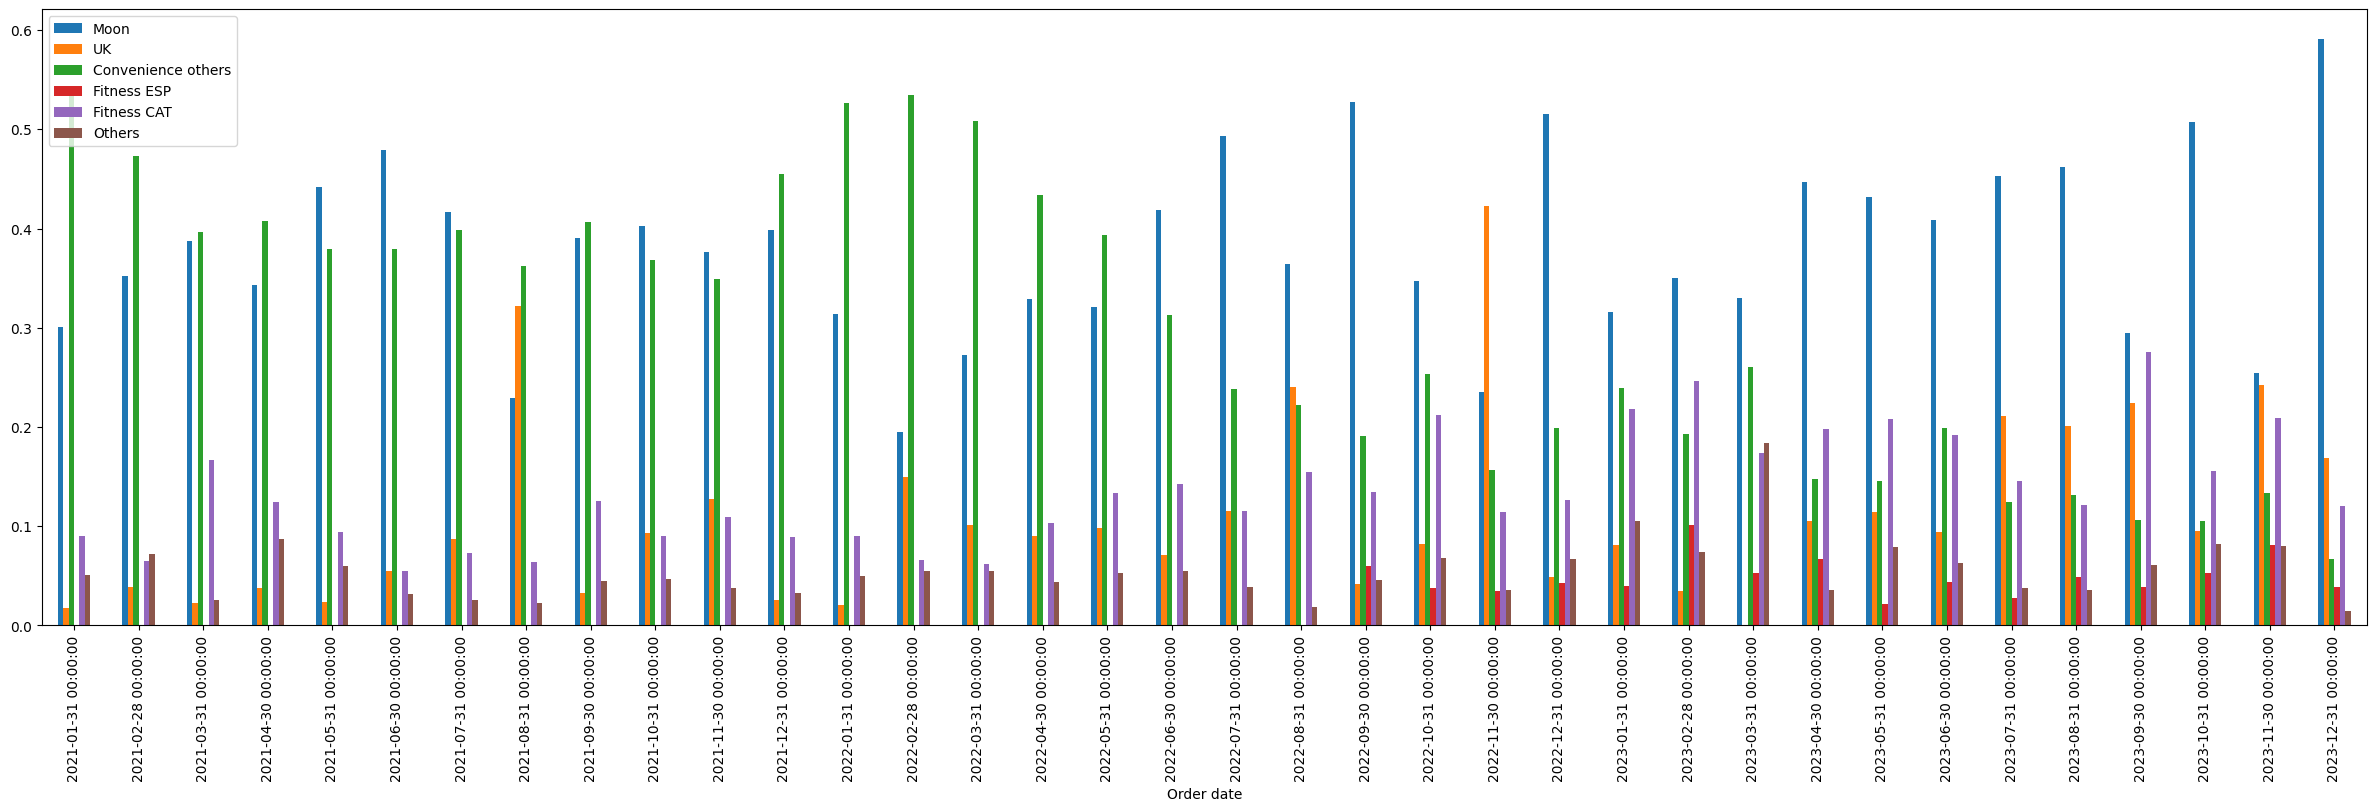

In [ ]:
# Una vez con las listas, ver unidades en marco temporal mensual
vars = [moon, uk, conve_others, fitness_ESP, fitness_CAT, others_cust]
unidades_grupos = pd.DataFrame(columns=['Moon', 'UK', 'Convenience others', 'Fitness ESP', 'Fitness CAT', 'Others'],
                               index=orders[orders.Address.isin(vars[0])].units.resample('M').sum().index)
for i in range(len(unidades_grupos.columns)):
    unidades_grupos[unidades_grupos.columns[i]] = orders[orders.Address.isin(vars[i])].units.resample('M').sum()

unidades_grupos.fillna(0, inplace=True)
((unidades_grupos.T / unidades_grupos.sum(1)).T).plot(kind='bar', figsize=(30,8))

In [ ]:
unidades_grupos.loc['2023']

In [ ]:
condis_moon = (
    'Carrer de Còrsega. 516',
    'Rambla Poble Nou. 38',
    'Carrer Entenca 85',
    'Calle Ronda Guinardo 40',
    'Calle Balmes 466',
    'Carrer del Rosselló, 466',
    'Carrer de Bailén, 93',
    'Doctor Ferran, 49',
    'Carrer de la Industria, 10',
    'Sardenya 45 (Condis)',
    'Calle Pere 4, 177',
    'Equador 92',
    'C/ Tallers 45',
    'Carrer de Sant Antoni Maria Claret 41',
    'Carrer del Bruc 32',
    'Carrer del Clot 177',
    'Carrer Lepant 389',
    'Plaza Maragall 16',
    'C/ de Aragón, 406',
    'C/ Roser 38.',
    'C/ Mandri 45',
    'Mallorca 96'
    )

fg_milkshakes = ['Barebells Protein Milkshake Chocolate', 'Barebells Protein Milkshake Vanilla']

non_fg_references = [
    'Barebells Hazelnut & Nougat',
    'Barebells Protein Milkshake Strawberry',
    'Barebells White Salty Peanut',
    'Barebells Bars Coco Choco ',
                     ]

all_barebells = barebells + milkshake
fg_references = [x for x in all_barebells if x not in non_fg_references]
fg_references = list(dict.fromkeys(fg_references))

failed_order = orders[(orders.Address.isin(condis_moon)) & (orders['Product description'].isin(fg_references))].loc['2022-12-01':]

# failed_order[['Order number', 'Address', 'Customer number', 'Customer description', 'Product description', 'units']].to_excel('Condis_Moon_Sales_Milkshakes.xlsx')

number_orders = failed_order.loc['2023-06':, 'Order number'].unique()

failed_order[failed_order['Order number'].isin(number_orders)][['Order number', 'Address', 'Product description', 'units']]

In [ ]:
# Sacar las barritas y batidos vendidos a los Condis directamente nosotros
df_filtered_nonfg = orders[(orders.Address.isin(condis_moon)) & (orders['Product description'].isin(all_barebells))].loc['2023-08']

nonfg = pd.DataFrame(index=df_filtered_nonfg.Address.unique(), columns = df_filtered_nonfg['Product description'].unique())

for shop in nonfg.index:
    for product in nonfg.columns:
        nonfg.loc[shop, product] = df_filtered_nonfg[(df_filtered_nonfg.Address == shop) & (df_filtered_nonfg['Product description'] == product)].units.sum()

nonfg.sum(0)

In [ ]:
# Vamos a Sacar un DF que contenga:
  # - indice direcciones
  # - columnas units per Brand {NOCCO, VW, soft, bars, milkshakes}, Seller, last order, total orders, Cadena, Zip code, Nombre, Agrupación? Moon, UK, etc...

# Eliminar los valores nan de las direcciones
orders_cat_2023.dropna(subset=['Address'], inplace=True)

# Añadir el feature de brand
# Con esto se coge los nombrs de las referencias en cada marca
def check(sentence, words):
    res = [all([k in s for k in words]) for s in sentence]
    return [sentence[i] for i in range(0, len(res)) if res[i]]

def remove_words(lista, words):
    first = [types for types in lista if not types.startswith(words[0])]
    return [types for types in first if not types.__contains__(words[1])]

nocco = check(orders_cat_2023['Product description'].unique(), ['NOCCO'])
milkshake = check(orders_cat_2023['Product description'].unique(), ['Milkshake'])
vitamin = check(orders_cat_2023['Product description'].unique(), ['Vitamin'])

# Con las barritas es más complejo
barritas = list(filter(lambda x: x not in (nocco + vitamin + milkshake), list(set(orders_cat_2023['Product description'].unique()))))
soft_bars = check(barritas, ['Soft'])

# Esto se tiene que hacer manualmente, no hay otra opción
soft_bars.append('Barebells Bars Coco Choco ')

original_bars = list(filter(lambda x: x not in soft_bars, barritas))

# Generar una lista con todos los marcas
brands = [nocco, vitamin, soft_bars, original_bars, milkshake]
brands_names = ['NOCCO_units', 'Vitamin_units', 'Soft_units', 'Original_units', 'Milkshake_units']

# Reducir la dimensionalidad de las cadenas
cadenas_mapping = {
    'Fitness': ['Fitness', 'Crossfit', 'Box', 'Gym', 'Nutrition', 'Gimnasio/deporte', 'Padel', 'Tennis', 'Golf'],
    'Convenience': ['Carrefour Express', 'Convenience', 'Supermercado/Tienda', 'Supermarket', 'Carrefour Hiper'],
    'Otros': ['Other', 'Otros', 'Grab&GO', 'Farmacia', 'Panaderia, Pasteleria, cafeter', 'Gas', 'Al por menor', 'Hostelería', 'Hotel', 'Restaurante', 'STOP&GO', 'Food Service'],
} # Agrega otras cadenas según sea necesario
for cadena, chain_list in cadenas_mapping.items():
    orders_cat_2023.loc[orders_cat_2023['Chain'].isin(chain_list), 'Chain'] = cadena

# Generar el DF
full_2023_customers = pd.DataFrame(
    index=orders_cat_2023.Address.unique(),
    columns=['Zip code', 'CU', 'Name', 'Chain', 'Group', 'Seller', 'Last order', 'Total orders',
        'NOCCO_units', 'Vitamin_units', 'Soft_units', 'Original_units', 'Milkshake_units'],
    dtype='float64')

for direc in orders_cat_2023.Address.unique():
    mask = orders_cat_2023.Address == direc
    full_2023_customers.loc[direc, 'Zip code'] = orders_cat_2023[mask]['Zip code'].unique()[0]
    full_2023_customers.loc[direc, 'CU'] = orders_cat_2023[mask]['Customer number'].unique()[0]
    full_2023_customers.loc[direc, 'Name'] = orders_cat_2023[mask]['Customer description'].unique()[0]
    full_2023_customers.loc[direc, 'Chain'] = orders_cat_2023[mask]['Chain'].unique()[0]
    if direc in moon:
        full_2023_customers.loc[direc, 'Group'] = 'Moon'
    elif direc in uk:
        full_2023_customers.loc[direc, 'Group'] = 'UK'
    else:
        full_2023_customers.loc[direc, 'Group'] = 'Independent'
    full_2023_customers.loc[direc, 'Seller'] = orders_cat_2023[mask]['Seller'].unique()[0]
    full_2023_customers.loc[direc, 'Last order'] = orders_cat_2023[mask].index[-1].strftime('%Y-%m-%d')
    full_2023_customers.loc[direc, 'Total orders'] = orders_cat_2023[mask].index.unique().shape[0]

    for i in range(len(brands)):
        mask = (orders_cat_2023.Address == direc) & (orders_cat_2023['Product description'].isin(brands[i]))
        if len(orders_cat_2023[mask]) > 0:
            full_2023_customers.loc[direc, brands_names[i]] = orders_cat_2023[mask].units.sum()
        else:
            full_2023_customers.loc[direc, brands_names[i]] = 0

# Eliminamos clientes que no han contado o que podrían estar duplicados por haber sido introducidos mal en Genero
full_2023_customers.dropna(subset=['CU'], inplace=True)
full_2023_customers.info()

In [ ]:
orders_moon = orders[(orders.Address.isin(moon))]
orders_moon = orders_moon.loc['2022']

moon_df = pd.DataFrame(
    index=moon,
    columns=['Zip code', 'Name', 'Soft_units', 'Original_units', 'Vitamin_units', 'Milkshake_units', 'NOCCO_units'],
    dtype='float64')
for direc in orders_moon.Address.unique():
    mask = orders_moon.Address == direc
    moon_df.loc[direc, 'Zip code'] = orders_moon[mask]['Zip code'].unique()[0]
    moon_df.loc[direc, 'Name'] = orders_moon[mask]['Customer description'].unique()[0]

    for i in range(len(brands)):
        mask = (orders_moon.Address == direc) & (orders_moon['Product description'].isin(brands[i]))
        if len(orders_moon[mask]) > 0:
            moon_df.loc[direc, brands_names[i]] = orders_moon[mask].units.sum()
        else:
            moon_df.loc[direc, brands_names[i]] = 0


In [ ]:
moon_df

In [ ]:
# full_2023_customers.to_excel('full_2023_customers.xlsx')

# Parte 3
Predicción de ventas futuras


## Preprocessing data

In [ ]:
# Esto solo se tiene que hacer si me mandan mal el Excel y me aparecen TODOS los comerciales
# esto es Para chequear si hay más de un comericial en el DataFrame de 2023
'''
españa_2023 = orders_2023
# Apply some improvements
españa_2023['Order date'] = pd.to_datetime(españa_2023['Order date'])
españa_2023.set_index('Order date', inplace=True)

españa_2023['Zip code'].fillna(0, inplace=True)
españa_2023['Zip code'] = [str(int(españa_2023['Zip code'][x])).zfill(5) for x in range(len(españa_2023))]

españa_2023['units'] = españa_2023['Quantity'] * españa_2023['Units/Box']

# En este caso el orders viene desde 2020 con TODOS los comerciales, así que es necesario filtrar con el nombre del comercial
orders = españa_2023[españa_2023.Seller == 'Roger Salvador']
'''

"\nespaña_2023 = orders_2023\n# Apply some improvements\nespaña_2023['Order date'] = pd.to_datetime(españa_2023['Order date'])\nespaña_2023.set_index('Order date', inplace=True)\n\nespaña_2023['Zip code'].fillna(0, inplace=True)\nespaña_2023['Zip code'] = [str(int(españa_2023['Zip code'][x])).zfill(5) for x in range(len(españa_2023))]\n\nespaña_2023['units'] = españa_2023['Quantity'] * españa_2023['Units/Box']\n\n# En este caso el orders viene desde 2020 con TODOS los comerciales, así que es necesario filtrar con el nombre del comercial\norders = españa_2023[españa_2023.Seller == 'Roger Salvador']\n"

In [ ]:
# Create a smallest group of shops, based on Moon, UK, convenience, fitness and others but only based in customers owned directly by me, not throught third-party

no_crusat = (
    'Mallorca 272',
    'Villaroel 199',
    'Passeig de Lluís Companys. 17',
    'Ronda San Pedro. 13',
    'Avda. Gaudi. 2',
    'CALLE TRAFALGAR, 5.',
    'Carrer Fontanella 10',
)

last_customers = moon + uk + no_crusat + tuple(set(fitness_ESP)) + tuple(set(fitness_CAT)) + tuple(set(others_cust))

# This line of code is what uses a different variables for the orders process
orders_no_cursat = orders[orders.Address.isin(last_customers)]

In [ ]:
from sklearn.preprocessing import LabelEncoder

col_interest = ['Address', 'Zip code', 'City', 'Chain', 'Product description', 'units']

# Change between the two options
# df = orders_no_cursat[col_interest]
df = orders[col_interest]

pd.options.mode.chained_assignment = None

df['year'] = df.index.year.values
df['month'] = df.index.month.values
df['day'] = df.index.dayofweek.values

df = df.reset_index().drop(columns=['Order date'])

In [ ]:
y = df['units']
cats = df[['Address', 'Zip code', 'City', 'Chain', 'Product description']]
cont = df[['year', 'month', 'day']]

def encoder(df):
    for col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype('str'))
    return df

df_cat = encoder(cats)

x = pd.concat([df_cat, cont], axis=1)

In [ ]:
from matplotlib.axes import SecondaryAxis
from itertools import product
years = list(set(pd.Series(map(lambda x: x.year, orders.index.date)).unique()))
months = range(1,13)

season_comb = pd.DataFrame(index=months, columns=['year'])
season_comb['year'] = years[0]
season_comb.reset_index(inplace=True)

s_comb2 = season_comb.copy()
s_comb2['year'] = years[1]

s_comb3 = season_comb.copy()
s_comb3['year'] = years[2]

try:
    s_comb4 = season_comb.copy()
    s_comb4['year'] = years[3]
    season_comb = pd.concat([season_comb, s_comb2, s_comb3, s_comb4], 0)

except:
    season_comb = pd.concat([season_comb, s_comb2, s_comb3], 0)

season_comb.columns = ['month', 'year']
season_comb = season_comb.reset_index().drop('index', 1).reset_index()
season_comb.columns = ['date_block', 'month', 'year']
season_comb.date_block = season_comb.date_block + 1


x['date_block'] = np.nan

for ye in x.year.unique():
  for m in x.month.unique():
    try:
      x.loc[(x.month == m) & (x.year == ye), 'date_block'] = season_comb.loc[(season_comb.month == m) & (season_comb.year == ye), 'date_block'].values[0].astype(np.int16)
    except:
      pass

data = pd.concat([x,y], 1)
data.shape

<ipython-input-56-3f016f56be04>:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  season_comb = pd.concat([season_comb, s_comb2, s_comb3], 0)
<ipython-input-56-3f016f56be04>:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  season_comb = season_comb.reset_index().drop('index', 1).reset_index()
<ipython-input-56-3f016f56be04>:39: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pd.concat([x,y], 1)


(36952, 10)

In [ ]:
# Ver el total de posibilidades
n_clients = len(data.Address.unique())
n_references = len(data['Product description'].unique())
n_blocks = len(data.date_block.unique())

print(n_clients, n_references, n_blocks)
n_clients * n_references * n_blocks

347 33 35


400785

In [ ]:
# Crear la matriz con todas las posibilidades
ma = []
for i in data.date_block.unique():
  ma.append(np.array(list(product([i], data.Address.unique(), data['Product description'].unique()))))
matrix = pd.DataFrame(np.vstack(ma), columns=['date_block','Address','Product description'])
matrix.shape

(400785, 3)

In [ ]:
# Añadir caracterísitcas a la matriz
cols= ['date_block','Address','Product description']

group = data.groupby(['date_block','Address','Product description']).agg({'units': ['sum']})
group.columns = ['units_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left').fillna(0)

In [ ]:
# Caracterísitcas de geolocalización
def get_customer_val(df, fix_col, val_col): return df.groupby([fix_col])[val_col].mean().values

cust_info = pd.DataFrame(data.Address.unique(), columns=['Address'])
cols = ['Zip code', 'City', 'Chain']
for co in cols:
    cust_info[co] = get_customer_val(data, 'Address', co)

matrix = pd.merge(matrix, cust_info, on=['Address'], how='left')

In [ ]:
# Caracterísiticas de temporalaidad
def get_seasonality(df, fix_col, val_col): return df.groupby([fix_col])[val_col].min().values

season = pd.DataFrame(data.date_block.unique(), columns=['date_block'])
cols = ['year', 'month']
for co in cols:
    season[co] = get_seasonality(data, 'date_block', co)

matrix = pd.merge(matrix, season, on=['date_block'], how='left')

In [ ]:
# Caracterísiticas de tendencia de las ventas
group = matrix[['date_block', 'Address', 'Product description', 'units_month']]
matrix['units_month_lag1'] = group.merge(group.assign(date_block = group.date_block+1),
                                        on=['date_block', 'Address', 'Product description'],
                                        how='left', suffixes=['', '_lag1'])['units_month_lag1']

group = matrix.groupby(['Address', 'Product description']).agg({'units_month':['mean']})
group.columns = ['avg_units_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on = ['Address', 'Product description'], how = "left")
matrix.fillna(0, inplace=True)

## Train, test and valid splits

In [ ]:
#@title Split in Train & Valid
#@markdown Write year and month from where split between train and valid
n_month_valid = 10#@param {type:"number"}
n_year_valid = 2023#@param {type:"number"}

# Drop first month becouse has NaNs
matrix = matrix[matrix.date_block > 1]

# Split into train, valid and test
X = matrix.drop(columns=['units_month']).reset_index().drop(columns=['index'])
Y = matrix['units_month'].reset_index().drop(columns=['index'])

cond = (X['year'] >= n_year_valid) & (X['month'] == n_month_valid)
valid_idx = np.where(cond)[0]
train_idx = np.where(~cond)[0]

X_train = X.loc[train_idx]
y_train = Y.loc[train_idx]

X_valid = X.loc[valid_idx]
y_valid = Y.loc[valid_idx]

print(X_valid.shape, X_train.shape)
print(y_valid.shape, y_train.shape)

(11451, 10) (377883, 10)
(11451, 1) (377883, 1)


In [ ]:
#@markdown Write year and month what you want to predict
n_month_test = 11#@param {type:"number"}
n_year_test = 2023#@param {type:"number"}
X_test = X_valid.copy()
X_test.month = n_month_test
X_test.year = n_year_test
X_test.units_month_lag1 = y_valid
X_test.units_month_lag1.sum()

month_str = datetime.datetime(n_year_test, n_month_test, 1).strftime('%B')

#@markdown This cell return the shape of X_test matrix
print('Predicting units will be sold in {} of {}'.format(
    month_str,
    X_test.year.unique()[0]
    ))
X_test.shape

Predicting units will be sold in November of 2023


(11451, 10)

## Prepare to train algorithm

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import math

rf = RandomForestRegressor(n_estimators=2000,
                           criterion='squared_error',
                           verbose=1,
                           n_jobs=-1,
                           random_state=42,
                           max_samples=None,
                           min_samples_leaf=4)

rf.fit(X_train, y_train.values.reshape(-1))

def r_mse(pred,y): return round(math.sqrt(((pred.reshape(-1,1)-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

m_rmse(rf, X_valid, y_valid)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 22.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Do

9.538926

In [ ]:
rf.predict(X_valid).sum().round(2), y_valid.sum()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:    2.7s finished


(19115.38,
 units_month    23940.0
 dtype: float64)

In [ ]:
rf.predict(X_test).sum().round(2)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:    2.7s finished


20296.78

## Make a Prediction

In [ ]:
#@title Make a prediction
# Put the dates to make future predictions
range_preds = X_test

# Final predictions
scal_cust = LabelEncoder()
scal_cust.fit(df['Address'].astype('str'))
scal_cust.inverse_transform(range_preds['Address'].astype('int'))

scal_product = LabelEncoder()
scal_product.fit(df['Product description'])
scal_product.inverse_transform(range_preds['Product description'].astype('int'))

preds_values = rf.predict(range_preds)
preds = pd.DataFrame(preds_values.round(2), columns=['units_predicted'])
preds['Address'] = scal_cust.inverse_transform(range_preds['Address'].astype('int'))
preds['Product description'] = scal_product.inverse_transform(range_preds['Product description'].astype('int'))


preds = preds.groupby(['Address', 'Product description']).sum()

print('\nTotal units predicted for {}-{} is: {}\n'.format(
    X_test.year.unique()[0],
    X_test.month.unique()[0],
    preds_values.sum().round(2)
))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    1.7s



Total units predicted for 2023-11 is: 20296.78



[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:    2.5s finished


## Visualice some insights on predictions

In [ ]:
df_pred = preds.reset_index()
oo = (df_pred.units_predicted / 10 + df_pred.units_predicted- X_train.loc[X_train.date_block == 11, 'avg_units_month'].values) / 2
oo.fillna(0, inplace=True)
oo = oo.replace([np.inf], 2)

def sigmoid(x): return 1/(1+math.exp(-x))
df_pred['probability'] = oo.apply(sigmoid).values
df_pred.groupby('Address').sum().sort_values(by='units_predicted', ascending=False).head(30)

<ipython-input-69-67a3027224e8>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pred.groupby('Address').sum().sort_values(by='units_predicted', ascending=False).head(30)


,units_predicted,probability
Address,,
"Carrer d Aribau, 11",1362.27,22.648306
Ronda Universitat 3,1133.74,28.510856
"Av. del Marqués de L Argentera, 21",1109.98,27.076708
Carrer de Bergara 5,1045.16,28.637834
Calle Consell de Cent 357,919.90,25.493479
Gran Via de les Cortes Catalanes. 636,827.94,28.979605
Rambla de Catalunya 22,522.03,27.406712
Rambla Poble Nou. 38,504.81,24.113491
Carrer Entenca 85,444.89,20.118156


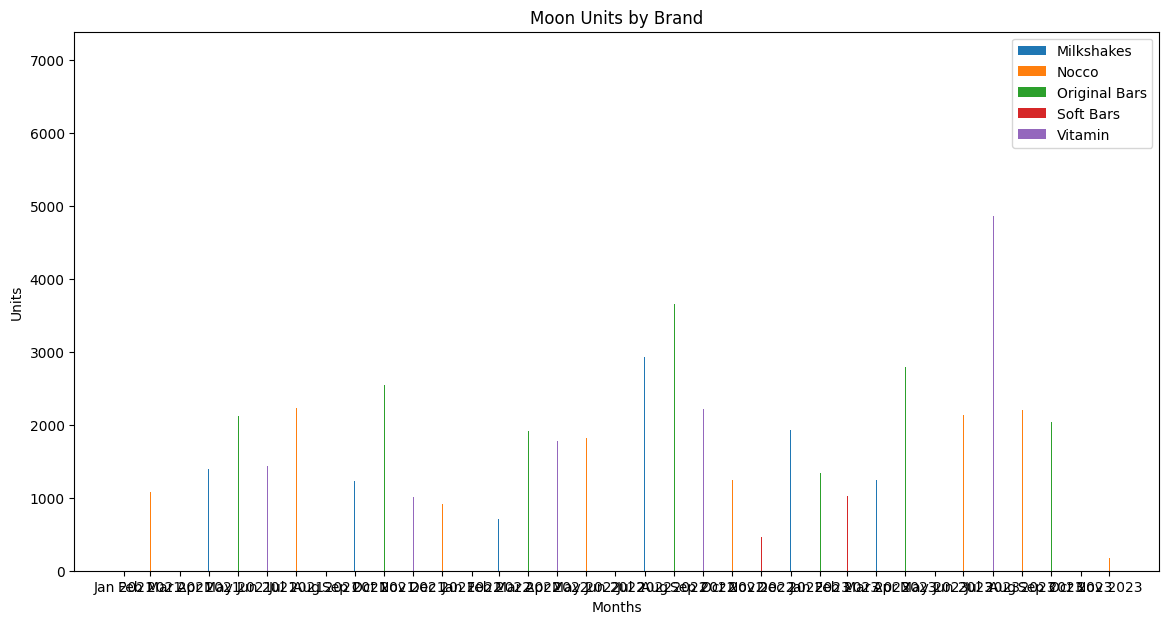

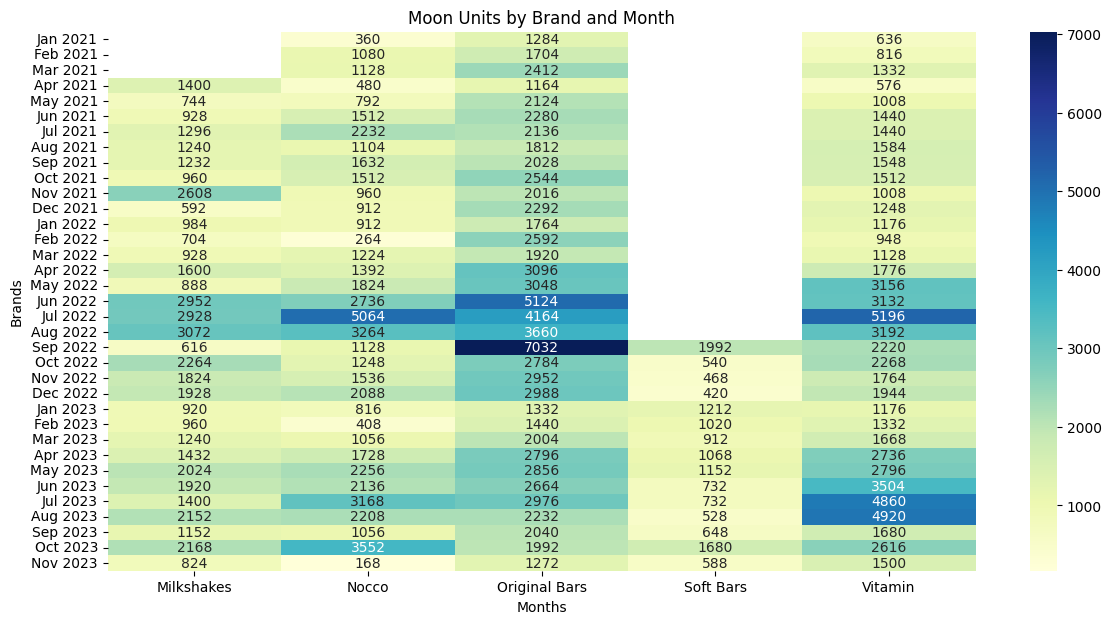

In [ ]:
# Con esto buscamos ver la evolución de Moon entre sus marcas y sus productos
barritas = [
    'Barebells Bars White Chocolate Almond',
    'Barebells Cookies & Cream',
    'Barebells Caramel Cashew',
    'Barebells Hazelnut & Nougat',
    'Barebells Salty Peanut',
    'Barebells White Salty Peanut',
    'Barebells Soft Bar Caramel Choco',
    'Barebells Bars Coco Choco ',
    'Barbells Soft Bar Peanut Caramel',
    'NO USAR Barebells Cookies & Cream',
    'NO USAR Barebells Caramel Cashew',
    'NO USAR Barebells Bars Cookies and Cream',
    'NO USAR Barebells Bars Salted Peanuts'
]

soft_bars = [
    'Barebells Soft Bar Caramel Choco',
    'Barebells Bars Coco Choco ',
    'Barbells Soft Bar Peanut Caramel',
]
original_bars = [
    'Barebells Bars White Chocolate Almond',
    'Barebells Cookies & Cream',
    'Barebells Caramel Cashew',
    'Barebells Hazelnut & Nougat',
    'Barebells Salty Peanut',
    'Barebells White Salty Peanut',
    'NO USAR Barebells Cookies & Cream',
    'NO USAR Barebells Caramel Cashew',
    'NO USAR Barebells Bars Cookies and Cream',
    'NO USAR Barebells Bars Salted Peanuts'
]

# Let's take a look on Moon units by shop and by product in 2023
moon_df = orders[orders.Address.isin(moon)]

# Vamos a añadir una nueva columna para poder buscar también dentro de brands
moon_df['Brand'] = np.nan
brands = [soft_bars, original_bars, nocco, vitamin, milkshake]
names_col = ['Soft Bars', 'Original Bars', 'Nocco', 'Vitamin', 'Milkshakes']
for name, brand in zip(names_col, brands):
    moon_df['Brand'][moon_df['Product description'].isin(brand)] = name

# En esto busca la mejor solución en función de lo que se quiera visualizar
moon_df = moon_df.groupby('Brand')['units'].resample('M').sum().unstack()
# Solo si se quiere exportar a excel
# moon_df.to_excel('moon_units.xlsx')

moon_df = moon_df.T

figure, ax = plt.subplots(figsize=(14, 7))

# Ajustar el ancho de las barras para evitar la superposición
width = 0.2  # Puedes ajustar este valor según tus preferencias

# Obtener las fechas convertidas a un formato numérico
x_values = [date.toordinal() for date in moon_df.index]

for i, brand in enumerate(moon_df.columns):
    # Desplazar cada barra horizontalmente
    ax.bar([x + i * width for x in x_values], moon_df[brand], width=width, label=brand)

ax.legend()
ax.set_xlabel('Months')
ax.set_ylabel('Units')
ax.set_title('Moon Units by Brand')
ax.set_xticks(x_values)
ax.set_xticklabels(moon_df.index.strftime('%b %Y'))  # Formato personalizado de las etiquetas del eje x

plt.show()

import seaborn as sns

plt.figure(figsize=(14, 7))
moon_df.index = moon_df.index.strftime('%b %Y')
sns.heatmap(moon_df, cmap='YlGnBu', annot=True, fmt='g', cbar=True)

plt.xlabel('Months')
plt.ylabel('Brands')
plt.xticks(rotation=0)
plt.title('Moon Units by Brand and Month')
plt.show()

In [ ]:
def searcher_shop(shop_list):
    df_search = pd.DataFrame(columns=['Last_buy', 'Bars', 'NOCCO', 'VW', 'Shakes', 'Total'])

    for address_shop in shop_list:
        pred_shop = df_pred[df_pred.Address == address_shop]
        ord_shop = orders[orders.Address == address_shop]
        try:
            df_search.loc[address_shop, 'Last_buy'] = ord_shop.index[-1].date()
            df_search.loc[address_shop, 'Bars'] = pred_shop.loc[pred_shop['Product description'].isin(barritas), 'units_predicted'].sum() / 12
            df_search.loc[address_shop, 'NOCCO'] = pred_shop.loc[pred_shop['Product description'].isin(nocco), 'units_predicted'].sum() / 24
            df_search.loc[address_shop, 'VW'] = pred_shop.loc[pred_shop['Product description'].isin(vitamin), 'units_predicted'].sum() / 12
            df_search.loc[address_shop, 'Shakes'] = pred_shop.loc[pred_shop['Product description'].isin(milkshake), 'units_predicted'].sum() / 8
            df_search['Total'] = df_search[['Bars', 'NOCCO', 'VW', 'Shakes']].sum(1)
        except:
            df_search.loc[address_shop, 'Last_buy'] = np.nan
            df_search.loc[address_shop, 'Bars'] = np.nan
            df_search.loc[address_shop, 'NOCCO'] = np.nan
            df_search.loc[address_shop, 'VW'] = np.nan
            df_search.loc[address_shop, 'Shakes'] = np.nan
            df_search['Total'] = np.nan
    return df_search


preds_out = searcher_shop(orders.Address.dropna().unique())
days_ago = (datetime.datetime.today() - datetime.timedelta(days=15)).strftime('%Y-%m-%d')
preds_out[preds_out['Last_buy'] < datetime.datetime.strptime(days_ago, '%Y-%m-%d').date()].sort_values(by='Total', ascending=False).head(20)

,Last_buy,Bars,NOCCO,VW,Shakes,Total
Ronda Universitat 3,2023-11-10,66.478333,3.007083,12.736667,13.87375,96.095833
Carrer de Bergara 5,2023-11-03,53.760833,3.030833,17.315833,14.9375,89.045000
Calle Consell de Cent 357,2023-11-08,42.646667,0.4425,18.729167,21.59625,83.414583
Rambla de Catalunya 22,2023-11-14,26.835833,3.335,5.941667,6.0825,42.195000
Travessera de Gràcia. 306,2023-11-13,16.7875,1.365833,3.116667,7.13375,28.403750
Passeig de Lluís Companys. 17,2023-11-13,9.368333,0.9625,6.524167,8.4325,25.287500
C/ Muntaner. 124,2023-11-13,12.378333,0.02625,0.0,9.13875,21.543333
Mallorca 272,2023-11-07,4.975833,0.0,6.04,5.51625,16.532083
"C/Ausias March, 9-11",2023-10-19,2.979167,0.00375,3.436667,8.7725,15.192083
C/Cami d'en Morato 7 Pol industrial Domenys 1,2023-11-09,0.0,15.003333,0.0,0.0,15.003333


In [ ]:
logistic_moon = (
    'Rambla Poble Nou. 38',
    'Carrer Entenca 85',
    'Calle Balmes 466',
    'Paseo Maragall 305',
    'Av. del Marqués de L Argentera, 21',
    'Carrer d Aribau, 11',
    'Carrer de Còrsega. 516',
    'Travessera de Gràcia. 306',
)

preds_out = searcher_shop(list(set(logistic_moon + uk)))
days_ago = (datetime.datetime.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
preds_out[preds_out['Last_buy'] < datetime.datetime.strptime(days_ago, '%Y-%m-%d').date()].sort_values(by='Total', ascending=False).head(30)

,Last_buy,Bars,NOCCO,VW,Shakes,Total
"Carrer d Aribau, 11",2023-11-24,46.855833,3.30125,28.618333,47.16875,125.944167
Ronda Universitat 3,2023-11-10,66.478333,3.007083,12.736667,13.87375,96.095833
"Av. del Marqués de L Argentera, 21",2023-11-16,36.753333,8.916667,23.564167,21.52125,90.755417
Carrer de Bergara 5,2023-11-03,53.760833,3.030833,17.315833,14.9375,89.045000
Calle Consell de Cent 357,2023-11-08,42.646667,0.4425,18.729167,21.59625,83.414583
Gran Via de les Cortes Catalanes. 636,2023-11-23,27.903333,2.942917,19.349167,23.785,73.980417
Rambla Poble Nou. 38,2023-11-20,11.705,1.005417,25.635833,4.07,42.416250
Rambla de Catalunya 22,2023-11-14,26.835833,3.335,5.941667,6.0825,42.195000
Carrer Entenca 85,2023-11-17,10.8325,1.82375,16.678333,8.87375,38.208333
Paseo Maragall 305,2023-11-20,19.161667,3.242083,3.501667,10.91,36.815417


### Añadir más filtros a las predicciones para buscar posibes ventas faciles



In [ ]:
referencia = 'Barebells Bars Coco Choco '

filtered_reference = orders[(orders['Product description'].isin(nocco)) & (orders.Address.isin(list(set(logistic_moon + uk))))].Address.unique()

lista_vendida = orders[(orders.Address.isin(filtered_reference)) & (orders['Product description'] == referencia)].Address.unique()
lista_no_vendida = list(set(filtered_reference) - set(lista_vendida))
lista_no_vendida

['Balmes 6', 'Carrer de Aragón 282', 'Carrer de Pelai 53.', "C/ d'Escuder 10"]

In [ ]:
# Buscador de tiendas
palabras =['Entença', '516','561' ]

coincidences = []
for palabra in palabras:
  coincidences.append([address for address in clientes_activos if palabra in address])

{x for l in coincidences for x in l}

{'Carrer Entença 64', 'Carrer de Còrsega. 516'}

Insights from Carrer de Còrsega. 516


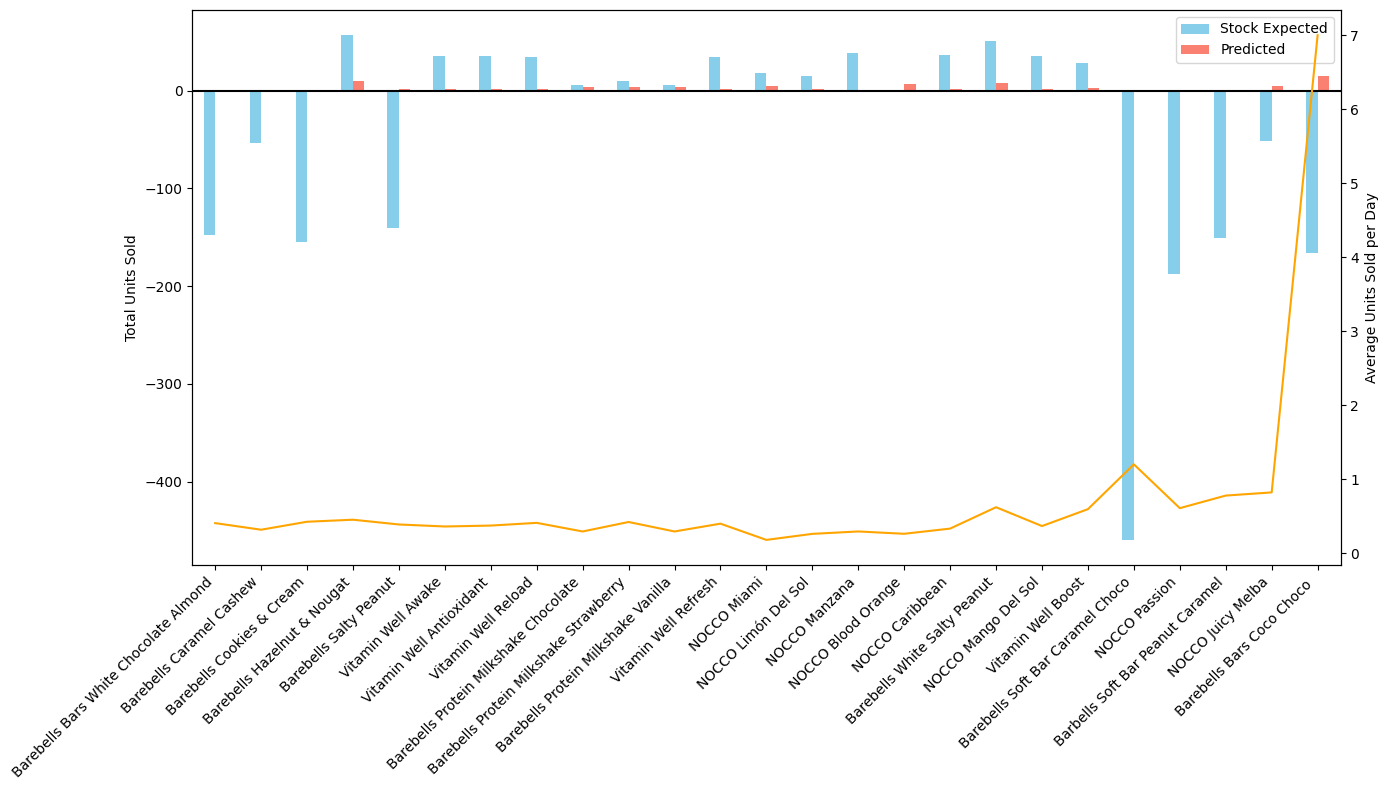

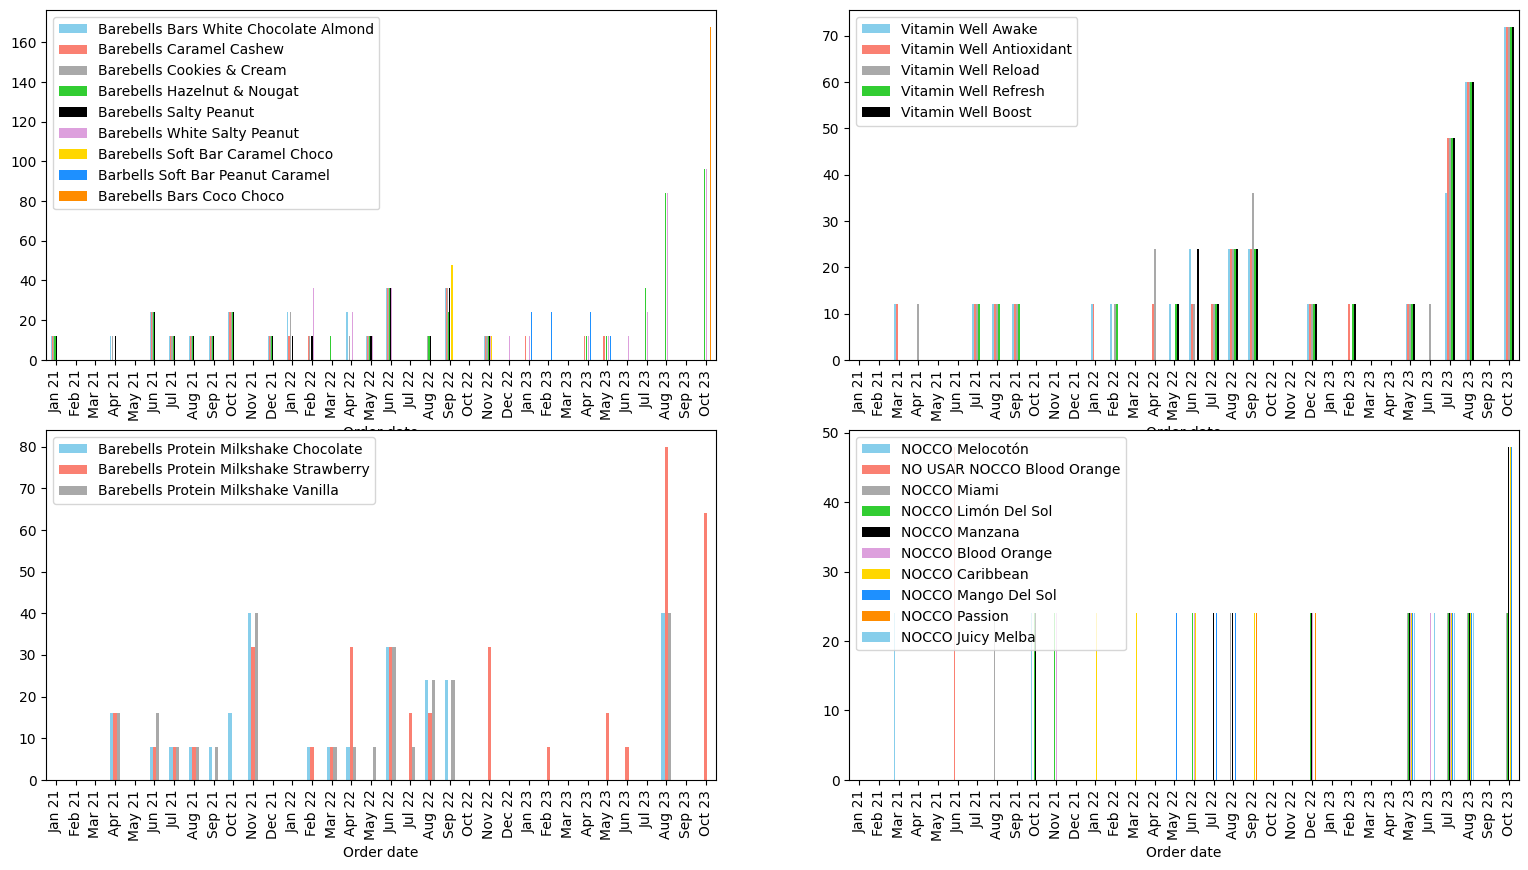

,Last Buy,Avg sold per day,Total sold,Last ammount buyed,Stock Expected,Predicted
Barebells Bars White Chocolate Almond,2022-11-02,0.40553,264,12,-147.373272,0.38
Barebells Cookies & Cream,2022-11-02,0.423963,276,12,-154.617512,0.29
Barebells Salty Peanut,2022-11-02,0.387097,252,12,-140.129032,1.51
Barebells Soft Bar Caramel Choco,2022-11-02,1.2,60,12,-459.6,0.62
NOCCO Passion,2022-12-16,0.607595,48,24,-188.050633,0.11
Barebells Caramel Cashew,2023-05-05,0.316168,264,12,-54.079042,0.20
Barbells Soft Bar Peanut Caramel,2023-05-05,0.777778,84,12,-150.555556,0.97
Barebells Protein Milkshake Chocolate,2023-08-04,0.292453,248,40,5.490566,3.75
Barebells Protein Milkshake Vanilla,2023-08-04,0.292453,248,40,5.490566,3.96
NOCCO Juicy Melba,2023-08-30,0.820513,96,24,-51.487179,4.81


In [ ]:
#@markdown # Solo hay que poner una dirección de un cliente antiguo para poder ver como evolucionan las ventas en un punto de venta
shop_address = 'Carrer de C\xF2rsega. 516' #@param {type:"string"}

'''
habria que ver como se puede mejorar el average sold per day y en consecuencia el stock de cada tienda
'''
delisted_products = ['Vitamin Well Care', 'NOCCO Melocotón']

# Usar también el algortimo predictivo para contrastarlo con las unidades que hay en stock
preds_in_shop = preds.loc[shop_address]
no_used_prod = [no for no in preds_in_shop.index if no.startswith("NO ") or no.find("NO ") != -1]

preds_in_shop.drop(no_used_prod, inplace=True)
for deli in delisted_products:
  try:
    preds_in_shop.drop(deli, inplace=True)
  except:
    pass

df_full_shop = orders[orders.Address == shop_address]

# Create the DataFrame with columns and index is regarding to the different Kind of products
df_insights = pd.DataFrame(index=df_full_shop['Product description'].unique(), columns=['Last Buy',
                                                                                        'Avg sold per day',
                                                                                        'Total sold',
                                                                                        'Last ammount buyed',
                                                                                        'Stock Expected'])

print('Insights from {}'.format(shop_address))
for p in df_full_shop['Product description'].unique():
    df_full_shop_product = df_full_shop[df_full_shop['Product description'] == p]

    df_insights.loc[p, 'Last Buy'] = df_full_shop_product.index.max().date()

    if df_full_shop_product.index.max() != df_full_shop_product.index.min():
        days = (df_full_shop_product.index.max() - df_full_shop_product.index.min()).days
        days_until_today = (pd.to_datetime(datetime.date.today()) - df_full_shop_product.index.max()).days

        df_insights.loc[p, 'Avg sold per day'] = df_full_shop_product.units.sum() / days
        df_insights.loc[p, 'Total sold'] = df_full_shop_product.units.sum()
        df_insights.loc[p, 'Last ammount buyed'] = df_full_shop_product.loc[df_full_shop_product.index.max().date().strftime('%Y-%m-%d')].units.sum()
        df_insights.loc[p, 'Stock Expected'] = df_full_shop[df_full_shop['Product description'] == p].units[-1] - (df_full_shop_product.units.sum() / days) * days_until_today

    else:
        days = (pd.to_datetime(datetime.date.today())  - df_full_shop_product.index.min()).days

        df_insights.loc[p, 'Avg sold per day'] = df_full_shop_product.units.sum() / days
        df_insights.loc[p, 'Total sold'] = df_full_shop_product.units.sum()
        df_insights.loc[p, 'Last ammount buyed'] = df_full_shop_product.loc[df_full_shop_product.index.max().date().strftime('%Y-%m-%d')].units.sum()
        df_insights.loc[p, 'Stock Expected'] = df_full_shop[df_full_shop['Product description'] == p].units[-1] - (df_full_shop_product.units.sum() / days) * days_until_today

import re
nocco_shop = [no for no in df_insights.index if no.startswith("NOCCO ") or no.find("NOCCO ") != -1]
nocco_no_used = [no for no in nocco_shop if no.startswith("NO ") or no.find("NO ") != -1]
for n in nocco_no_used:
    good_name = re.search(r'NOCCO(\s+\w+)*', n).group()
    df_insights.loc[good_name, 'Total sold'] = df_insights.loc[good_name, 'Total sold'] + df_insights.loc[n, 'Total sold']

df_insights.drop(nocco_no_used, inplace=True)
for deli in delisted_products:
  try:
    df_insights.drop(deli, inplace=True)
  except:
    pass
# Add in same DataFrame predictions from algorithm with the same index
df_insights['Predicted'] = preds_in_shop

# Select colours to make a plot
colors = ['skyblue',
          'salmon',
          'darkgrey',
          'limegreen',
          'k',
          'plum',
          'gold',
          'dodgerblue',
          'darkorange']

# Hacer un plot con el df_insights
fig, ax1 = plt.subplots(figsize=(14,8))

df_insights[['Stock Expected', 'Predicted']].plot(kind='bar', ax=ax1, color=colors)

ax1.axhline(0, color='k')
ax1.set_ylabel('Total Units Sold')

ax2 = ax1.twinx()
ax2.plot(df_insights['Avg sold per day'], color='orange')
ax2.set_ylabel('Average Units Sold per Day')

fig.autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

brands_sold_shop = pd.DataFrame(index=df_full_shop.units.resample('M').sum().index, columns=df_full_shop['Product description'].unique())

sold_by_prod_monthly = df_full_shop.groupby('Product description').units.resample('M').sum()
for prod in sold_by_prod_monthly.index.levels[0]:
    brands_sold_shop[prod] = sold_by_prod_monthly.loc[prod]

brands_sold_shop.fillna(0, inplace=True)
brands_sold_shop.index = brands_sold_shop.index.strftime('%b %y')

fig, ax = plt.subplots(2,2, figsize=(19,10), sharex=False)

to_plot = brands_sold_shop[brands_sold_shop.columns[brands_sold_shop.columns.isin(barritas)]]
to_plot.plot(kind='bar', color=colors, ax = ax[0,0])

to_plot = brands_sold_shop[brands_sold_shop.columns[brands_sold_shop.columns.isin(vitamin)]]
to_plot.plot(kind='bar', color=colors, ax = ax[0,1])

to_plot = brands_sold_shop[brands_sold_shop.columns[brands_sold_shop.columns.isin(milkshake)]]
to_plot.plot(kind='bar', color=colors, ax = ax[1,0])

to_plot = brands_sold_shop[brands_sold_shop.columns[brands_sold_shop.columns.isin(nocco)]]
to_plot.plot(kind='bar', color=colors, ax = ax[1,1])

plt.show()

df_insights.sort_values(by='Last Buy')

In [ ]:
# Transformar la fecha de Año-semana año-día semana a Año-Mes-Dia

fecha_input = "2023-43-5"

fecha_output = datetime.datetime.strptime(fecha_input, "%Y-%W-%w")
fecha_output = fecha_output.strftime("%Y-%m-%d")

# Calucular diferencia entre fechas
inicio_fecha = '2023-10-09'
final_fecha = fecha_output
n_dias = (datetime.datetime.strptime(final_fecha, "%Y-%m-%d") - datetime.datetime.strptime(inicio_fecha, "%Y-%m-%d")).days

print(f'La fecha con la semana {datetime.datetime.strptime(fecha_input, "%Y-%W-%w").isocalendar()[1]}, se convierte en fecha: {fecha_output}')
print(f'La diferencia entre la fecha {inicio_fecha} y la fecha {final_fecha} son {n_dias} días')

La fecha con la semana 43, se convierte en fecha: 2023-10-27
La diferencia entre la fecha 2023-10-09 y la fecha 2023-10-27 son 18 días


In [ ]:
df_shop_info = df_full_shop[['Product description', 'units']].groupby(['Product description', pd.Grouper(freq='D')]).sum().reset_index().pivot(index='Product description',
                                                                                                                                               columns='Order date',
                                                                                                                                               values='units').fillna(0)

df_shop_info.T.loc['2023'].T

Order date,2023-01-19,2023-02-07,2023-02-24,2023-03-20,2023-04-06,2023-05-19,2023-07-06,2023-07-19,2023-08-01,2023-08-08,2023-09-06,2023-09-14,2023-09-27,2023-10-09,2023-10-27
Product description,,,,,,,,,,,,,,,
Barbells Soft Bar Peanut Caramel,24.0,24.0,24.0,12.0,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Barebells Bars Coco Choco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,36.0
Barebells Bars White Chocolate Almond,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Barebells Caramel Cashew,0.0,12.0,12.0,0.0,24.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0
Barebells Cookies & Cream,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Barebells Hazelnut & Nougat,0.0,12.0,12.0,0.0,24.0,24.0,12.0,24.0,24.0,0.0,60.0,0.0,24.0,0.0,36.0
Barebells Protein Milkshake Chocolate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Barebells Protein Milkshake Strawberry,8.0,16.0,0.0,8.0,0.0,16.0,8.0,0.0,80.0,80.0,40.0,40.0,0.0,160.0,0.0
Barebells Protein Milkshake Vanilla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part 4
Visualización geoespacial de unidades y clientes

In [ ]:
from geopy.geocoders import Nominatim

#if your sites are located in France only you can use the country_bias parameters to restrict search
geolocator = Nominatim(user_agent = 'roger.salva92@gmail.com')

In [ ]:
!pip install folium
import folium
map = folium.Map(location=[41.399964, 2.1639139],tiles='cartodbpositron', zoom_start=9)

from folium import plugins
from folium import plugins
from folium.plugins import HeatMap
import numpy as np

In [ ]:
for i in range(len(heat_data)):
    folium.Marker(heat_data[i]).add_to(map)
map

In [ ]:
address = orders.Address.unique()

address_df = pd.DataFrame(index=address, columns=['Zip_code', 'City', 'Address', 'LAT', 'LON'])
for addre in address:
    address_df.loc[addre]['City'] = orders[orders.Address == addre][['City', 'Zip code']].iloc[0,:].City
    address_df.loc[addre]['Zip_code'] = orders[orders.Address == addre][['City', 'Zip code']].iloc[0,:]['Zip code']
    address_df.loc[addre]['Address'] = str(addre)+str(', ')+str(address_df.City.loc[addre])+str(', ')+str(address_df.Zip_code.loc[addre])

for x in range(len(address_df.Address)):
    try:
        address_df.loc[address_df.index.values[x]]['LAT'] = geolocator.geocode(address_df.Zip_code.values[x]+', '+address_df.City.values[x]).latitude
        address_df.loc[address_df.index.values[x]]['LON'] = geolocator.geocode(address_df.Zip_code.values[x]+', '+address_df.City.values[x]).longitude
    except:
        address_df.loc[address_df.index.values[x]]['LAT'] = np.nan
        address_df.loc[address_df.index.values[x]]['LON'] = np.nan

heat_df = address_df[['LAT', 'LON']].astype('float').dropna()
heat_data = [[row['LAT'],row['LON']] for index, row in heat_df.iterrows()]
Marker(data=heat_data, radius=10).add_to(map)

map

NameError: ignored

## Añadimos más información cortesia de Sebastián con información de todos los puntos de Venta en España

In [ ]:
# esto es Para chequear si hay más de un comericial en el DataFrame de 2023
españa_2023 = orders_2023
# Apply some improvements
españa_2023['Order date'] = pd.to_datetime(españa_2023['Order date'])
españa_2023.set_index('Order date', inplace=True)

españa_2023['Zip code'].fillna(0, inplace=True)
españa_2023['Zip code'] = [str(int(españa_2023['Zip code'][x])).zfill(5) for x in range(len(españa_2023))]

españa_2023['units'] = españa_2023['Quantity'] * españa_2023['Units/Box']

In [ ]:
# Filtrando por el nombre del comercial se puede ver que clientes son los más fuertes
comercial = 'Nicolás Pyzynski'

top_comercial = españa_2023[españa_2023.Seller == comercial].groupby('Customer number').units.sum().sort_values(ascending=False).head(20).index
for cu_comercial in top_comercial:
    data_cu = españa_2023[(españa_2023['Customer number'] == cu_comercial)]
    if len(data_cu['Customer description'].unique()) > 1.5:
      for i in range(0, len(data_cu['Customer description'].unique())):
        new_data_cu = data_cu[data_cu['Customer description'] == data_cu['Customer description'].unique()[i]]
        print('For {} in {}, made a total units of {} from day {}'.format(new_data_cu['Customer description'].unique()[0],
                                                                          new_data_cu['City'].unique()[0],
                                                                          new_data_cu.units.sum(),
                                                                          new_data_cu.index.min().strftime('%Y-%m-%d')
                                                                ))
    else:
        print('For {} in {}, made a total units of {} from day {}'.format(data_cu['Customer description'].unique()[0],
                                                                          data_cu['City'].unique()[0],
                                                                          data_cu['units'].sum(),
                                                                          data_cu.index.min().strftime('%Y-%m-%d')
                                                                ))

españa_2023[españa_2023.Seller == comercial].units.resample('M').sum()

In [ ]:
address = pd.DataFrame(españa_2023['Customer number'].unique()).dropna().values.flatten().tolist()

address_df = pd.DataFrame(index=address, columns=['Zip_code', 'City', 'Address', 'LAT', 'LON', 'units'])
for addre in address:
    address_df.loc[addre]['City'] = españa_2023[españa_2023['Customer number'] == addre][['City', 'Zip code']].iloc[0,:].City
    address_df.loc[addre]['Zip_code'] = españa_2023[españa_2023['Customer number'] == addre][['City', 'Zip code']].iloc[0,:]['Zip code']
    address_df.loc[addre]['Address'] = str(addre)+str(', ')+str(address_df.City.loc[addre])+str(', ')+str(address_df.Zip_code.loc[addre])
    address_df.loc[addre]['units'] = españa_2023[españa_2023['Customer number'] == addre].units.sum()

for x in range(len(address_df.Address)):
    try:
        address_df.loc[address_df.index.values[x]]['LAT'] = geolocator.geocode(address_df.Zip_code.values[x]+', '+address_df.City.values[x]).latitude
        address_df.loc[address_df.index.values[x]]['LON'] = geolocator.geocode(address_df.Zip_code.values[x]+', '+address_df.City.values[x]).longitude
    except:
        address_df.loc[address_df.index.values[x]]['LAT'] = np.nan
        address_df.loc[address_df.index.values[x]]['LON'] = np.nan

heat_df = address_df[['LAT', 'LON', 'units']].astype('float').dropna()
heat_data = [[row['LAT'],row['LON'], row['units']] for index, row in heat_df.iterrows()]
HeatMap(data=heat_data, radius=10).add_to(map)

map

In [ ]:
map.save('mapa_calor_NOCCO_distribuidores.html')

In [ ]:
cu_esp = españa_2023['Customer number'].unique()
clientes_esp = pd.DataFrame(index=cu_esp, columns = ['Zip', 'Dirección', 'Nombre', 'Cadena'])

for k in cu_esp:
    try:
        clientes_esp.loc[k, 'Zip'] = españa_2023[españa_2023['Customer number'] == k]['Zip code'].unique()[0]
        clientes_esp.loc[k, 'Dirección'] = españa_2023[españa_2023['Customer number'] == k]['Address'].unique()[0]
        clientes_esp.loc[k, 'Nombre'] = españa_2023[españa_2023['Customer number'] == k]['Customer description'].unique()[0]
        clientes_esp.loc[k, 'Cadena'] = españa_2023[españa_2023['Customer number'] == k]['Chain'].unique()[0]
    except:
        pass

clientes_esp



,Zip,Dirección,Nombre,Cadena
CU1776,29640,Avenida Las Salinas. Calle de Gran Canaria. 2,Kauppa Scandinavias Foods. S.L,Other
CU369,08202,C/ Marques De Comillas 87. Local A,Spartan Fitness,Gym
CU1247,08210,Carretera de . 241,Spartan Fitness Barb,Gym
CU1866,08025,Carrer Castillejos 386. baixos 1,Runandfit,Other
CU857,08002,Carrer de la Fusteria. 2,Hasad Hussain,Convenience
...,...,...,...,...
CU04275,29014,C/Alcalde Joaquin Quiles Nº15.,Farmacia Carmen Diaz Suarez y otros CB,Farmacia
CU04232,28026,MARCELO USERA 11.,ESTANCO USERA,Other
CU04251,36203,"C/ Nicaragua, 12.",IKIGAI TRAINING,Gimnasio/deporte
CU04277,08303,Rd. Dr. Turro 15.,Pasion por Cocinarte,Restaurante


In [ ]:
clientes_esp.to_excel('clientes_df.xlsx')